In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16

import cv2


import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report


import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
# Set dataset folder path
BASE_DATASET_FOLDER = os.path.join("C:\\Users\\BHAVYA\\Downloads","derma_disease_dataset","dataset")
TRAIN_FOLDER = "train"
VALIDATION_FOLDER = "validation"
TEST_FOLDER = "test"

# ResNet50 image size
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Keras settings
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.0001
MODEL_PATH = os.path.join("derma_diseases_detection.h5")

In [7]:
def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=True)

Found 938 images belonging to 3 classes.


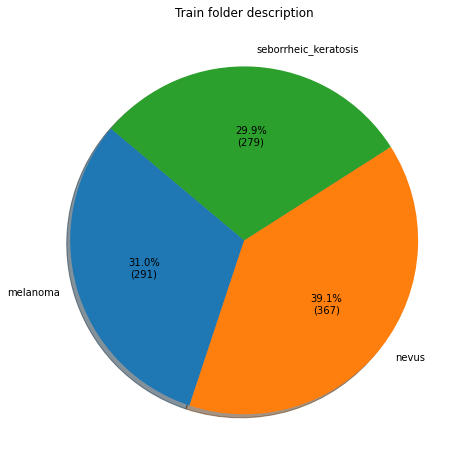

In [9]:
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER), "Train folder description")

In [10]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
        target_size=IMAGE_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 97 images belonging to 3 classes.


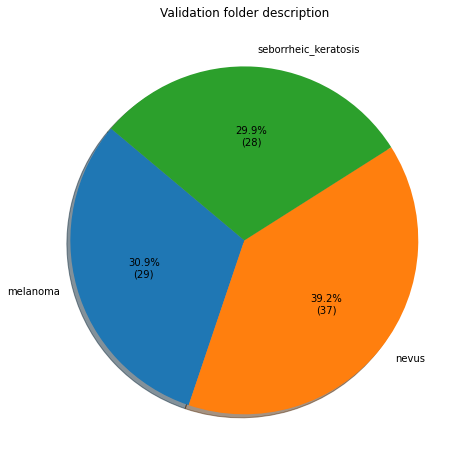

In [11]:
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),"Validation folder description")

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 368 images belonging to 3 classes.


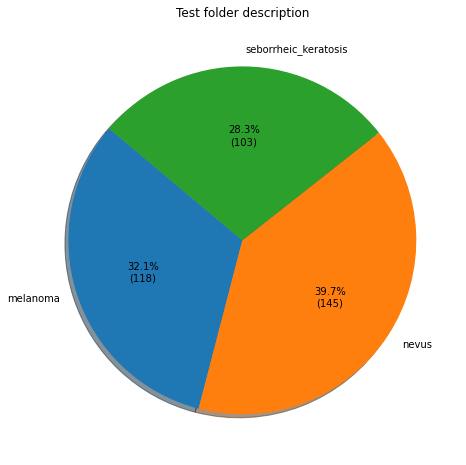

In [13]:
plot_dataset_description(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER), "Test folder description")

In [14]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}


In [15]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [16]:
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [17]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

In [18]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3

In [19]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

In [20]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size)

Epoch 1/50
14/14 [==============================] - 187s 13s/step - loss: 1.1762 - acc: 0.3924 - val_loss: 1.0178 - val_acc: 0.5417
Epoch 2/50
14/14 [==============================] - 219s 16s/step - loss: 0.9821 - acc: 0.5229 - val_loss: 0.8365 - val_acc: 0.6042
Epoch 3/50
14/14 [==============================] - 230s 16s/step - loss: 0.8834 - acc: 0.5984 - val_loss: 0.7586 - val_acc: 0.7083
Epoch 4/50
14/14 [==============================] - 211s 15s/step - loss: 0.8298 - acc: 0.6556 - val_loss: 0.6943 - val_acc: 0.6875
Epoch 5/50
14/14 [==============================] - 213s 15s/step - loss: 0.7912 - acc: 0.6602 - val_loss: 0.6667 - val_acc: 0.7292
Epoch 6/50
14/14 [==============================] - 213s 15s/step - loss: 0.7258 - acc: 0.7071 - val_loss: 0.7701 - val_acc: 0.6771
Epoch 7/50
14/14 [==============================] - 226s 16s/step - loss: 0.7317 - acc: 0.6979 - val_loss: 0.6968 - val_acc: 0.7083
Epoch 8/50
14/14 [==============================] - 228s 16s/step - loss: 0.

In [21]:
model.save(MODEL_PATH)

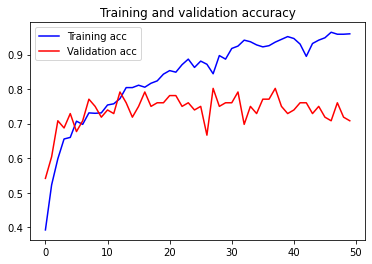

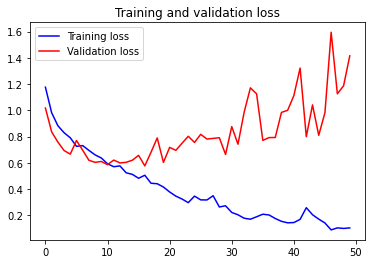

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [23]:
%%time
loss, accuracy = model.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)

CPU times: total: 4min 25s
Wall time: 50.9 s


In [24]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))

Accuracy: 0.684783
Loss: 1.793265


In [25]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1, steps=test_generator.samples//test_generator.batch_size)

46/46 [==============================] - 55s 1s/step
CPU times: total: 4min 48s
Wall time: 55.9 s


In [26]:
y_pred = np.argmax(Y_pred, axis=1)

In [27]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

In [30]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

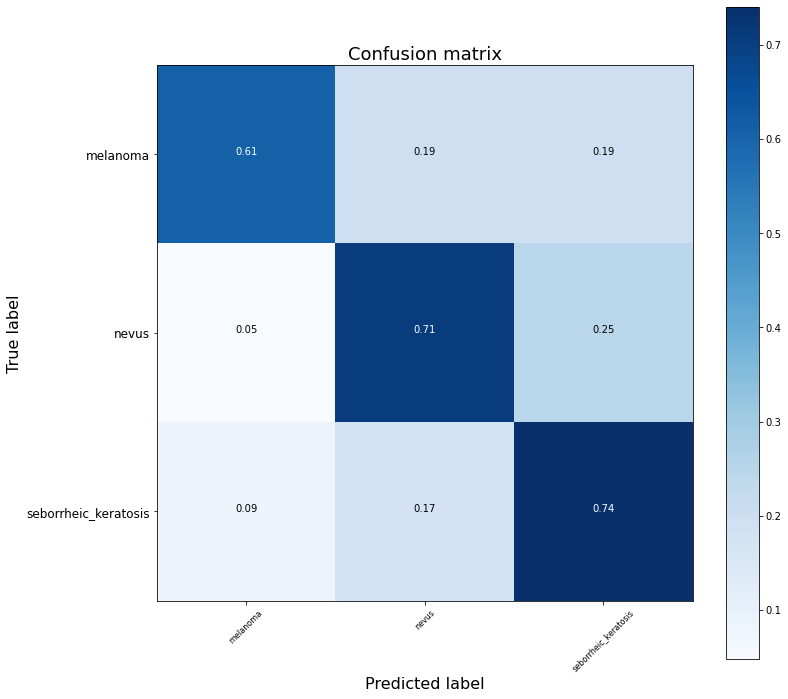

In [31]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [32]:
print(classification_report(test_generator.classes, y_pred, target_names=list(classes.values())))

                      precision    recall  f1-score   support

            melanoma       0.82      0.61      0.70       118
               nevus       0.72      0.71      0.71       146
seborrheic_keratosis       0.57      0.74      0.64       104

            accuracy                           0.68       368
           macro avg       0.70      0.69      0.68       368
        weighted avg       0.71      0.68      0.69       368



In [33]:
def load_image(filename):
    img = cv2.imread(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis\ISIC_0013085.jpg
1/1 [==============================] - 0s 439ms/step
PREDICTED: class: seborrheic_keratosis, confidence: 0.999999


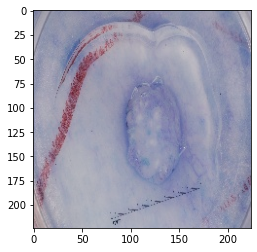

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus\ISIC_0013164.jpg
1/1 [==============================] - 0s 200ms/step
PREDICTED: class: nevus, confidence: 0.999390


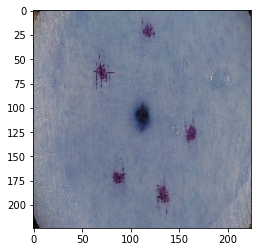

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis\ISIC_0013200.jpg
1/1 [==============================] - 0s 216ms/step
PREDICTED: class: nevus, confidence: 0.788815


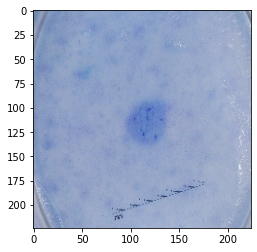

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis\ISIC_0013958.jpg
1/1 [==============================] - 0s 148ms/step
PREDICTED: class: seborrheic_keratosis, confidence: 0.769699


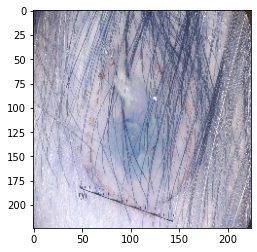

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus\ISIC_0012539.jpg
1/1 [==============================] - 0s 170ms/step
PREDICTED: class: nevus, confidence: 0.675507


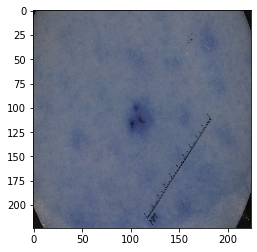

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis\ISIC_0014191.jpg
1/1 [==============================] - 0s 237ms/step
PREDICTED: class: melanoma, confidence: 0.551224


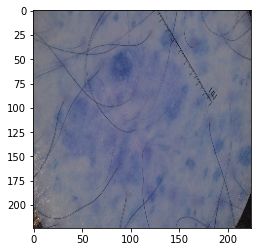

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus\ISIC_0012737.jpg
1/1 [==============================] - 0s 136ms/step
PREDICTED: class: seborrheic_keratosis, confidence: 0.983749


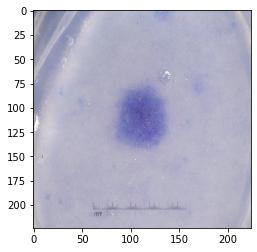

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus\ISIC_0013437.jpg
1/1 [==============================] - 0s 234ms/step
PREDICTED: class: melanoma, confidence: 0.630244


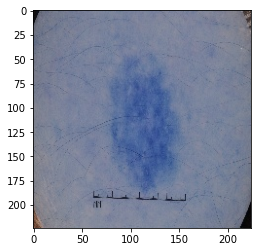

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus\ISIC_0013789.jpg
1/1 [==============================] - 0s 140ms/step
PREDICTED: class: melanoma, confidence: 0.967124


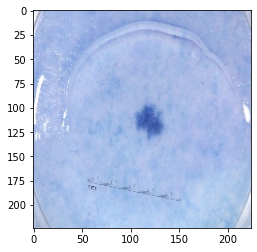

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus\ISIC_0013213.jpg
1/1 [==============================] - 0s 161ms/step
PREDICTED: class: nevus, confidence: 0.908866


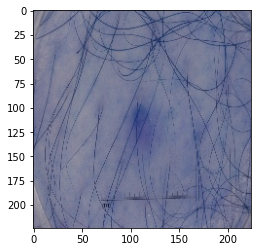

<Figure size 432x288 with 0 Axes>

In [34]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()